# COGS 108 - EDA Checkpoint

# Names

- Jonathan Chou
- Eli Marx-Kahn
- Kevin Lee
- Sherry Ma

<a id='research_question'></a>
# Research Question

Is there a relationship between temperature trends and number of suicides in New York City? 
More specifically:
1. Do suicide rates in a given season differ when average temperatures in that season deviate from typical* seasonal temperatures?
2. Do anomalously warm or cold seasons have a correlation with higher or lower than average suicide rates?
    - Does higher fluctuation in temperature have a correlation with higher or lower than average suicide rates?
3. Do suicide rates differ between men and women in years when there is higher temperature fluctuation?

***Typical refers here to the average seasonal temperature across the years 2008-2014**


# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#getting the suicide data
suicide_count_yearly = pd.read_csv("Data/Suicide counts and rates in New York City 2000-2014.csv")
suicide_count_seasonal = pd.read_csv("Data/Seasonal counts of suicide in New York City 2008-2014.csv")

#getting the temperature data from all 3 datasets
dataset_2007 = pd.read_csv("Data/2007.csv")
dataset_2008_to_2010 = pd.read_csv("Data/2008-10.csv")
dataset_2011_to_2013 = pd.read_csv("Data/2011-13.csv")
dataset_2014 = pd.read_csv("Data/2014.csv")

# Data Cleaning

### Suicide Data Cleaning

Initial Suicide Data Cleaning

In [2]:
## Suicide Data Cleaning

#the yearly suicide contains data from 2000-2014, we want to filter it out to 2008-2014
suicide_count_yearly['Year'] = suicide_count_yearly['Year'].astype(int)
suicide_count_yearly = suicide_count_yearly[suicide_count_yearly['Year'] >= 2008]
suicide_count_yearly = suicide_count_yearly.reset_index(drop=True)

#remove irrelevant columns (crude rate and ageadjusted rate)
suicide_count_yearly = suicide_count_yearly.iloc[:,:4]

#merge with the seasonal data
suicide_dataset = pd.merge(left=suicide_count_yearly, right=suicide_count_seasonal, how='inner')

#rename columns
new_columns = {'Winter':'Winter count of suicides (Total)', 'Spring':'Spring count of suicides (Total)', 
               'Summer':'Summer count of suicides (Total)', 'Fall':'Fall count of suicides (Total)'}
suicide_dataset = suicide_dataset.rename(new_columns, axis='columns')
suicide_dataset

,Year,Count of Suicides (Total),Count of suicides (Females),Count of suicides (Males),Winter count of suicides (Total),Spring count of suicides (Total),Summer count of suicides (Total),Fall count of suicides (Total)
0,2008,473,125,348,117,143,114,99
1,2009,475,115,360,129,103,128,115
2,2010,503,129,374,109,147,141,106
3,2011,509,128,381,126,133,137,113
4,2012,557,163,391,126,162,136,133
5,2013,550,146,404,142,158,133,117
6,2014,565,172,393,121,167,160,117


### Verifying Integrity of Dataset

Verifying Sum of Seasonal Counts to Total Yearly Counts

In [3]:
suicide_data_total_column = suicide_dataset['Count of Suicides (Total)']

#sum up seasonal total counts to check if matches yearly total count
season_columns = ['Winter count of suicides (Total)', 'Spring count of suicides (Total)', 
               'Summer count of suicides (Total)', 'Fall count of suicides (Total)']
sum_season_counts = suicide_dataset[season_columns].sum(axis=1)
print("Does seasonal suicide count match yearly total count? " + str(sum_season_counts.equals(suicide_data_total_column)))

Does seasonal suicide count match yearly total count? True


Verifying Sum of Gender Counts to Total Yearly Counts

In [4]:
#sum up gender specific counts to check if matches total count
gender_columns = ['Count of suicides (Females)', 'Count of suicides (Males)']
sum_gender_counts = suicide_dataset[gender_columns].sum(axis=1)
sum_gender_counts.equals(suicide_data_total_column)

##returned False, so checking which observations returned false
false_rows = suicide_dataset[sum_gender_counts.eq(suicide_data_total_column) == False]
false_rows

,Year,Count of Suicides (Total),Count of suicides (Females),Count of suicides (Males),Winter count of suicides (Total),Spring count of suicides (Total),Summer count of suicides (Total),Fall count of suicides (Total)
4,2012,557,163,391,126,162,136,133


**Analysis:** For this observation, the count of suicides for females (163) and the count of suicides for males (391) sum up to 554. This is different from the total count of suicides which may be due to human error. However, since $\frac{557-554}{557}$ < 1%, the margin of error is minimal which means that this observation can be kept.

### Temperature Data Cleaning

Initial temperature data cleaning

In [5]:
#combine temperature datasets to get one dataframe with data from 2008-2014
temperature_data = pd.concat([dataset_2007, dataset_2008_to_2010, dataset_2011_to_2013, dataset_2014], sort=True)

#remove irrelevant columns (TAVG, NAME, TOBS)
temperature_data = temperature_data.drop(['TAVG','TOBS'], axis=1)

#remove stations not in New York
temperature_data = temperature_data[temperature_data.NAME.str.contains("NY US")]

#filter stations where there are observations with no recorded TMAX and TMIN in timeframe
max_observations = temperature_data['NAME'].value_counts().max()
highest_observation_stations = temperature_data['NAME'].value_counts() == max_observations
highest_observation_stations = highest_observation_stations.index[highest_observation_stations]

#separate all highest observation stations into separate DataFrames
stations = []
for station in highest_observation_stations:
    stations.append(temperature_data[temperature_data['NAME'] == station])

#check for missing data 
for s in stations:
    print("Any missing data? " + str(s.isnull().values.any()))

Any missing data? False
Any missing data? False
Any missing data? False


**Analysis:** There is no missing data in the stations that had the highest observation counts. However, this does not mean that everyday in between 2008 and 2014 had a recorded observation as they could have coincidentally had the same amount of missing days. Thus, we will verify by comparing number of observations with number of days in those 4 years.

In [6]:
#check each station for duplicate dates
for s in stations:
    print("No Duplicate Date: " + str(s["DATE"].is_unique))
    
#calculate total number of days between 2007-2014
from datetime import date
f_date = date(2007, 12, 1)
l_date = date(2015, 1, 1) #up to and not including 1/1/2015
day_count = (l_date - f_date).days

print("Does total number of days match observation count: " + str(day_count == max_observations))

No Duplicate Date: True
No Duplicate Date: True
No Duplicate Date: True
Does total number of days match observation count: True


**Analysis:** Now that we have cleaned and verified each station's data, we will now assign each station to a variable for easier analysis. 

In [7]:
station1 = stations[0].reset_index(drop=True)
station2 = stations[1].reset_index(drop=True)
station3 = stations[2].reset_index(drop=True)
display(station1)
display(station2)
display(station3)

,DATE,NAME,STATION,TMAX,TMIN
0,2007-12-01,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,39.0,25.0
1,2007-12-02,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,47.0,20.0
2,2007-12-03,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,50.0,33.0
3,2007-12-04,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,36.0,29.0
4,2007-12-05,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,33.0,28.0
...,...,...,...,...,...
2583,2014-12-27,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,54.0,37.0
2584,2014-12-28,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,54.0,42.0
2585,2014-12-29,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,46.0,35.0
2586,2014-12-30,"JFK INTERNATIONAL AIRPORT, NY US",USW00094789,36.0,28.0


,DATE,NAME,STATION,TMAX,TMIN
0,2007-12-01,"NY CITY CENTRAL PARK, NY US",USW00094728,38.0,25.0
1,2007-12-02,"NY CITY CENTRAL PARK, NY US",USW00094728,36.0,20.0
2,2007-12-03,"NY CITY CENTRAL PARK, NY US",USW00094728,47.0,32.0
3,2007-12-04,"NY CITY CENTRAL PARK, NY US",USW00094728,34.0,28.0
4,2007-12-05,"NY CITY CENTRAL PARK, NY US",USW00094728,33.0,28.0
...,...,...,...,...,...
2583,2014-12-27,"NY CITY CENTRAL PARK, NY US",USW00094728,55.0,44.0
2584,2014-12-28,"NY CITY CENTRAL PARK, NY US",USW00094728,54.0,43.0
2585,2014-12-29,"NY CITY CENTRAL PARK, NY US",USW00094728,44.0,34.0
2586,2014-12-30,"NY CITY CENTRAL PARK, NY US",USW00094728,34.0,28.0


,DATE,NAME,STATION,TMAX,TMIN
0,2007-12-01,"LAGUARDIA AIRPORT, NY US",USW00014732,42.0,26.0
1,2007-12-02,"LAGUARDIA AIRPORT, NY US",USW00014732,38.0,21.0
2,2007-12-03,"LAGUARDIA AIRPORT, NY US",USW00014732,49.0,34.0
3,2007-12-04,"LAGUARDIA AIRPORT, NY US",USW00014732,35.0,30.0
4,2007-12-05,"LAGUARDIA AIRPORT, NY US",USW00014732,34.0,29.0
...,...,...,...,...,...
2583,2014-12-27,"LAGUARDIA AIRPORT, NY US",USW00014732,55.0,42.0
2584,2014-12-28,"LAGUARDIA AIRPORT, NY US",USW00014732,52.0,42.0
2585,2014-12-29,"LAGUARDIA AIRPORT, NY US",USW00014732,44.0,35.0
2586,2014-12-30,"LAGUARDIA AIRPORT, NY US",USW00014732,35.0,28.0


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [8]:
#create a new column that calculates average proxy through midrange
station1['TAVG'] = (station1['TMAX'] + station1['TMIN'])/2
station2['TAVG'] = (station2['TMAX'] + station2['TMIN'])/2
station3['TAVG'] = (station3['TMAX'] + station3['TMIN'])/2


#function that will add seasonal data and suicide data for a given dataframe
def calculate_seasonal_data(station):
    station = station.set_index(['DATE'])
    column_names = ['Year', 
                    'Winter (TMAX)', 'Winter (TMIN)', 'Winter (TAVG)', 'Winter (DEV)',
                    'Spring (TMAX)', 'Spring (TMIN)', 'Spring (TAVG)', 'Spring (DEV)',
                    'Summer (TMAX)', 'Summer (TMIN)', 'Summer (TAVG)', 'Summer (DEV)',
                    'Fall (TMAX)', 'Fall (TMIN)', 'Fall (TAVG)', 'Fall (DEV)']
    station_season_avg = pd.DataFrame(columns = column_names)
    
    #calculate seasonal average and extremes
    for i in range(7):
        year = str(2008 + i)
        station_season_avg = station_season_avg.append({'Year':year}, ignore_index=True)

        station_season_avg.at[i, 'Winter (TAVG)'] = station.loc[str(2007 + i) + '-12-01': year + '-02-28']['TAVG'].mean()
        station_season_avg.at[i, 'Spring (TAVG)'] = station.loc[year + '-03-01':year + '-5-31']['TAVG'].mean()
        station_season_avg.at[i, 'Summer (TAVG)'] = station.loc[year + '-06-01':year + '-08-31']['TAVG'].mean()
        station_season_avg.at[i, 'Fall (TAVG)'] = station.loc[year + '-09-01':year + '-11-31']['TAVG'].mean()

        station_season_avg.at[i, 'Winter (TMAX)'] = station.loc[str(2007 + i) + '-12-01': year + '-02-28']['TMAX'].max()
        station_season_avg.at[i, 'Spring (TMAX)'] = station.loc[year + '-03-01':year + '-5-31']['TMAX'].max()
        station_season_avg.at[i, 'Summer (TMAX)'] = station.loc[year + '-06-01':year + '-08-31']['TMAX'].max()
        station_season_avg.at[i, 'Fall (TMAX)'] = station.loc[year + '-09-01':year + '-11-31']['TMAX'].max()

        station_season_avg.at[i, 'Winter (TMIN)'] = station.loc[str(2007 + i) + '-12-01': year + '-02-28']['TMIN'].min()
        station_season_avg.at[i, 'Spring (TMIN)'] = station.loc[year + '-03-01':year + '-5-31']['TMIN'].min()
        station_season_avg.at[i, 'Summer (TMIN)'] = station.loc[year + '-06-01':year + '-08-31']['TMIN'].min()
        station_season_avg.at[i, 'Fall (TMIN)'] = station.loc[year + '-09-01':year + '-11-31']['TMIN'].min()
    
    winter_mean = station_season_avg['Winter (TAVG)'].mean()
    spring_mean = station_season_avg['Spring (TAVG)'].mean()
    summer_mean = station_season_avg['Summer (TAVG)'].mean()
    fall_mean = station_season_avg['Fall (TAVG)'].mean()
    
    #calculate deviation 
    for i in range(7):
        station_season_avg.at[i, 'Winter (DEV)'] = station_season_avg.at[i, 'Winter (TAVG)'] - winter_mean
        station_season_avg.at[i, 'Spring (DEV)'] = station_season_avg.at[i, 'Spring (TAVG)'] - spring_mean
        station_season_avg.at[i, 'Summer (DEV)'] = station_season_avg.at[i, 'Summer (TAVG)'] - summer_mean
        station_season_avg.at[i, 'Fall (DEV)'] = station_season_avg.at[i, 'Fall (TAVG)'] - fall_mean
    
    #include suicide by season 
    col = suicide_dataset.columns.values.tolist()[1:]
    station_season_avg = station_season_avg.join(suicide_dataset[col])
    
    return station_season_avg

#call the function to get the seasonal and suicide data for the given station
seasonal_station1 = calculate_seasonal_data(station1)
seasonal_station2 = calculate_seasonal_data(station2)
seasonal_station3 = calculate_seasonal_data(station3)

display(seasonal_station1)
display(seasonal_station2)
display(seasonal_station3)

,Year,Winter (TMAX),Winter (TMIN),Winter (TAVG),Winter (DEV),Spring (TMAX),Spring (TMIN),Spring (TAVG),Spring (DEV),Summer (TMAX),...,Fall (TMIN),Fall (TAVG),Fall (DEV),Count of Suicides (Total),Count of suicides (Females),Count of suicides (Males),Winter count of suicides (Total),Spring count of suicides (Total),Summer count of suicides (Total),Fall count of suicides (Total)
0,2008,67,11,36.1222,0.95873,95,14,58.6863,-0.735528,95,...,24,57.2253,-0.842229,473,125,348,117,143,114,99
1,2009,64,7,34.2833,-0.880159,92,13,58.1291,-1.29272,92,...,33,57.8297,-0.237834,475,115,360,129,103,128,115
2,2010,66,14,33.8278,-1.33571,101,19,60.7418,1.32003,101,...,31,58.9176,0.850078,503,129,374,109,147,141,106
3,2011,67,6,32.2556,-2.90794,103,20,60.5458,1.12395,103,...,32,59.5165,1.44898,509,128,381,126,133,137,113
4,2012,64,13,39.9944,4.83095,99,26,60.6242,1.20238,99,...,31,57.3077,-0.759812,557,163,391,126,162,136,133
5,2013,62,12,37.0278,1.86429,100,20,58.5196,-0.902194,100,...,23,57.467,-0.600471,550,146,404,142,158,133,117
6,2014,64,3,32.6333,-2.53016,92,13,58.7059,-0.71592,91,...,23,58.2088,0.141287,565,172,393,121,167,160,117


,Year,Winter (TMAX),Winter (TMIN),Winter (TAVG),Winter (DEV),Spring (TMAX),Spring (TMIN),Spring (TAVG),Spring (DEV),Summer (TMAX),...,Fall (TMIN),Fall (TAVG),Fall (DEV),Count of Suicides (Total),Count of suicides (Females),Count of suicides (Males),Winter count of suicides (Total),Spring count of suicides (Total),Summer count of suicides (Total),Fall count of suicides (Total)
0,2008,68,10,36.5389,1.15635,96,13,59.1601,-0.798553,96,...,23,56.5934,-1.35557,473,125,348,117,143,114,99
1,2009,67,6,34.1667,-1.21587,92,12,58.335,-1.62372,92,...,35,57.4396,-0.509419,475,115,360,129,103,128,115
2,2010,66,13,33.8667,-1.51587,103,19,61.4412,1.48249,103,...,34,59.0165,1.0675,503,129,374,109,147,141,106
3,2011,67,6,32.7222,-2.66032,104,20,61.1127,1.15406,104,...,33,59.6429,1.69388,509,128,381,126,133,137,113
4,2012,62,13,40.5,5.11746,100,25,60.9592,1.00047,100,...,31,56.9176,-1.0314,557,163,391,126,162,136,133
5,2013,62,11,36.9167,1.53413,98,19,59.4837,-0.475023,98,...,23,57.7967,-0.152276,550,146,404,142,158,133,117
6,2014,71,4,32.9667,-2.41587,92,13,59.219,-0.739729,91,...,22,58.2363,0.287284,565,172,393,121,167,160,117


,Year,Winter (TMAX),Winter (TMIN),Winter (TAVG),Winter (DEV),Spring (TMAX),Spring (TMIN),Spring (TAVG),Spring (DEV),Summer (TMAX),...,Fall (TMIN),Fall (TAVG),Fall (DEV),Count of Suicides (Total),Count of suicides (Females),Count of suicides (Males),Winter count of suicides (Total),Spring count of suicides (Total),Summer count of suicides (Total),Fall count of suicides (Total)
0,2008,69,12,37.8056,1.67302,100,14,60.2075,-0.49113,100,...,25,58.0879,-0.987441,473,125,348,117,143,114,99
1,2009,67,8,34.8556,-1.27698,94,14,59.2369,-1.46172,94,...,38,58.8681,-0.207221,475,115,360,129,103,128,115
2,2010,66,14,34.5611,-1.57143,103,20,62.6699,1.97129,103,...,37,60.7143,1.63893,503,129,374,109,147,141,106
3,2011,67,9,34.3889,-1.74365,104,19,61.1716,0.472923,104,...,33,60.3242,1.24882,509,128,381,126,133,137,113
4,2012,63,14,40.7333,4.60079,101,27,62.2974,1.59874,101,...,33,58.6099,-0.465463,557,163,391,126,162,136,133
5,2013,61,12,37.8,1.66746,100,19,60.0261,-0.672502,100,...,24,58.1978,-0.877551,550,146,404,142,158,133,117
6,2014,69,4,32.7833,-3.34921,93,13,59.281,-1.4176,93,...,22,58.7253,-0.350078,565,172,393,121,167,160,117


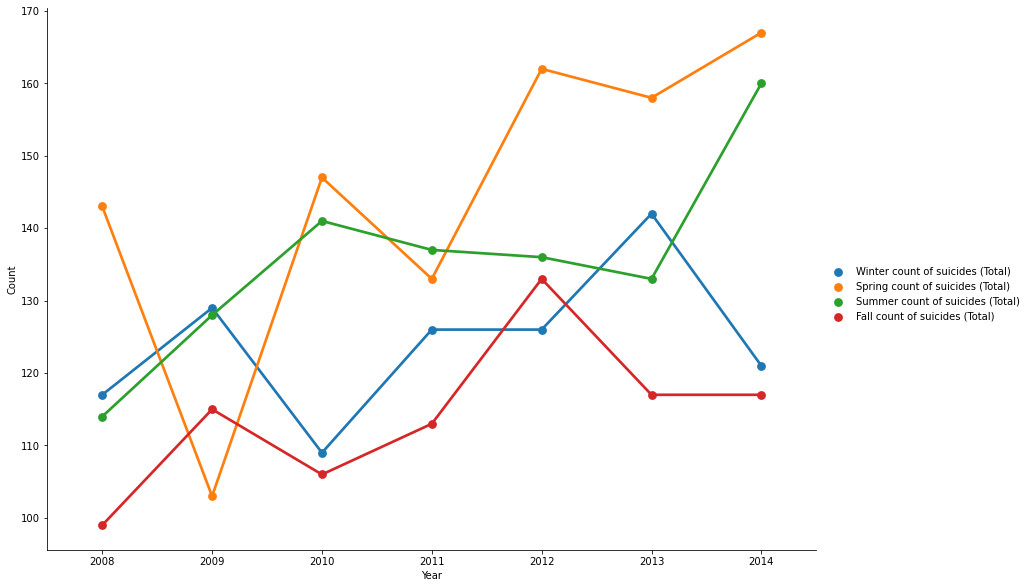

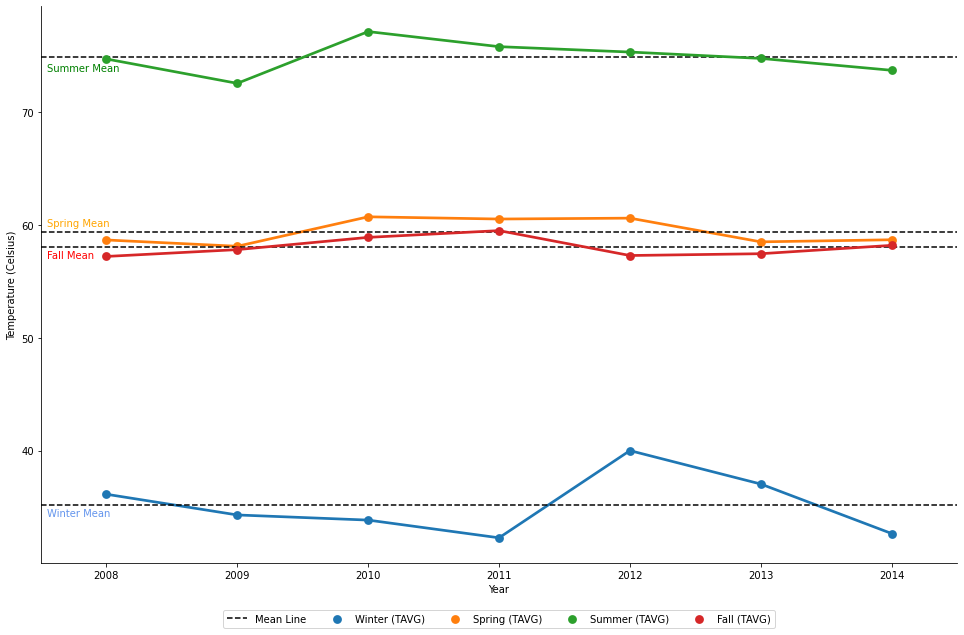

In [27]:
#cast as a float in order to display in graph
seasonal_station1 = seasonal_station1.astype(float)
seasonal_station1['Year'] = seasonal_station1['Year'].astype(int)

# to_drop = ['Winter (TMAX)', 'Winter (TMIN)', 'Winter (DEV)', 
#           'Spring (TMAX)', 'Spring (TMIN)', 'Spring (DEV)',
#           'Summer (TMAX)', 'Summer (TMIN)', 'Summer (DEV)',
#           'Fall (TMAX)', 'Fall (TMIN)', 'Fall (DEV)',
#            'Count of Suicides (Total)', 'Count of suicides (Males)', 'Count of suicides (Females)']
# season_avg_and_season_suicide = seasonal_station1.drop(columns=to_drop)

#show suicide data per season over the years
seasons_and_year = ['Year']
seasons_and_year.extend(season_columns)
seasonal_suicide_count = seasonal_station1[seasons_and_year]
data = seasonal_suicide_count.melt('Year', var_name='',  value_name='Count')
sns.catplot(x="Year", y="Count", hue='', data=data, kind='point', height=8.27, aspect=11.7/8.27)

#show season temperature data over the years
season_avg = ['Year', 'Winter (TAVG)', 'Spring (TAVG)', 'Summer (TAVG)', 'Fall (TAVG)']
season_avg = seasonal_station1[season_avg]
data = season_avg.melt('Year', var_name='',  value_name='Temp (Fahrenheit)')
graph = sns.catplot(x="Year", y="Temp (Fahrenheit)", hue='', data=data, kind='point', height=8.27, aspect=11.7/8.27)
graph._legend.remove() 

#show average line across the seasons, as a visual indicator for deviation from total average 
winter_mean = season_avg['Winter (TAVG)'].mean()
spring_mean = season_avg['Spring (TAVG)'].mean()
summer_mean = season_avg['Summer (TAVG)'].mean()
fall_mean = season_avg['Fall (TAVG)'].mean()

graph.map(plt.axhline, y=winter_mean, ls='--', c='black', label='Mean Line')
graph.map(plt.annotate, s="Winter Mean", xy=(-0.45,winter_mean-1), color='cornflowerblue')

graph.map(plt.axhline, y=spring_mean, ls='--', c='black')
graph.map(plt.annotate, s="Spring Mean", xy=(-0.45,spring_mean+0.5), color='orange')

graph.map(plt.axhline, y=summer_mean, ls='--', c='black')
graph.map(plt.annotate, s="Summer Mean", xy=(-0.45,summer_mean-1.2), color='green')

graph.map(plt.axhline, y=fall_mean, ls='--', c='black')
graph.map(plt.annotate, s="Fall Mean", xy=(-0.45,fall_mean-1), color='red')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.1), ncol=5)
graph.set_axis_labels("Year", "Temperature (Celsius)")